<a href="https://colab.research.google.com/github/kur0s4ki/Mask-Detection/blob/main/Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [12]:
dataset = 'dataset/'
plot = 'plot.png'
model_path = 'mask_detector.hdf5'


In [13]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 64

In [14]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('dataset/'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [15]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [16]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [17]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
17/17 [==============================] - 11s 654ms/step - loss: 0.6816 - accuracy: 0.6631 - val_loss: 0.1765 - val_accuracy: 0.9819
Epoch 2/50
17/17 [==============================] - 11s 646ms/step - loss: 0.2594 - accuracy: 0.8803 - val_loss: 0.0682 - val_accuracy: 0.9891
Epoch 3/50
17/17 [==============================] - 11s 619ms/step - loss: 0.1377 - accuracy: 0.9498 - val_loss: 0.0372 - val_accuracy: 0.9964
Epoch 4/50
17/17 [==============================] - 10s 613ms/step - loss: 0.1012 - accuracy: 0.9672 - val_loss: 0.0237 - val_accuracy: 0.9964
Epoch 5/50
17/17 [==============================] - 10s 617ms/step - loss: 0.0748 - accuracy: 0.9788 - val_loss: 0.0184 - val_accuracy: 0.9928
Epoch 6/50
17/17 [==============================] - 10s 616ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.0150 - val_accuracy: 0.9964
Epoch 7/50
17/17 [==============================] - 10s 614ms/step - loss: 0.0617 - accuracy

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(model_path, save_format="hdf5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

[INFO] saving mask detector model...


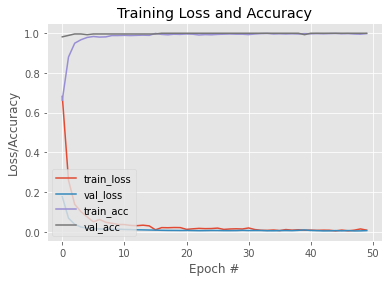

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot)

[INFO] loading face detector model...
[INFO] loading face mask detector model...


[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


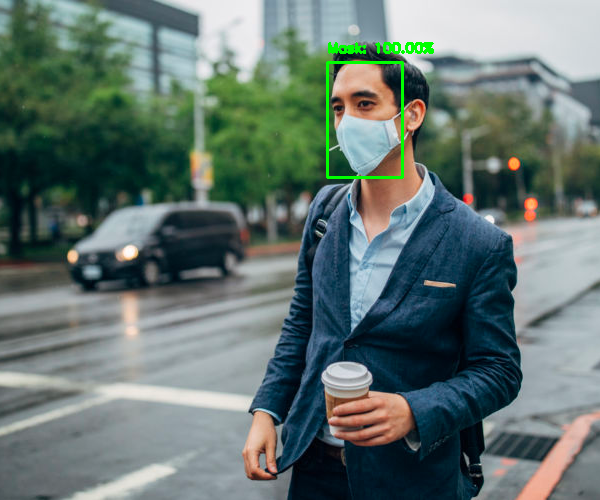

-1

In [34]:

from google.colab.patches import cv2_imshow
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os


face = "face_detector/"
model_saved = "mask_detector.hdf5"
confidence_param = 0.5

print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["face_detector/", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector/","res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.hdf5")

# dimensions
image = cv2.imread('examples/example_01.png')
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > confidence_param:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(image)
cv2.waitKey(0)